### Logistic Regression  
#### 1. 估计概率  
逻辑回归模型计算输入特征的加权和（加上偏置项），并输出结果的数理逻辑值  

逻辑回归的预测结果为：  

$$ \hat{y} = \sigma(w^T \theta)$$


其中$\sigma$为Sigmoid函数，其计算结果为概率  
$$\sigma(x) = \frac{1}{1+e^{-x}}$$

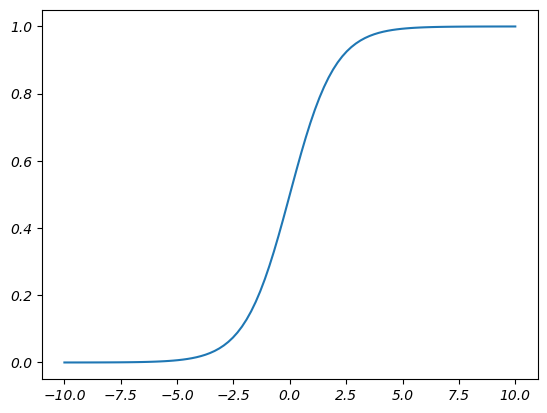

#### 2.训练和代价函数  
- 训练的目的就是设置参数向量$\theta$,使得模型对阳性类实例做出高概率估算，对阴性类实例做出低概率估算  
单个训练示例的代价函数：  
$$J(\theta)=\begin{cases} -log(h_\theta(x)) & \text{if } y=1 \\ -log(1-h_\theta(x)) & \text{if } y=0 \end{cases}$$


- 整个训练集的代价函数是所有训练实例的平均成本,可以用一个对数损失的单一表达式写出  
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m J(\theta^T x_i, y_i) = \frac{1}{m} \sum_{i=1}^m \left( \log(h_\theta(x_i)) - y_i \right)$$

- 该函数为一个凸函数，可以通过梯度下降等算法求出全局最小值,代价函数的偏导数为  
$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x_i) - y_i \right) x_{i,j}$$


#### 3. 逻辑回归的超参数  
- 逻辑回归的参数有C和penalty。C是正则化参数，penalty是正则化方法
- C越小，正则化越强，C越大，正则化越弱
- penalty有L1和L2两种，L1是Lasso回归，L2是Ridge回归  


#### 处理分类任务：依然使用一样的评论数据集

In [2]:
import pandas as pd 
import numpy as np 
import jieba 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False   
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec

In [3]:
df = pd.read_csv(
    r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\comments_data.csv',
    encoding='gbk'
)
print(df.head())
print(f'评论总数量：{len(df["comments"])}')

                                            comments  sentiment
0  买来用做PS和Pr等，性能非常强大，外观非常好看，很轻很薄，界面颜色很好看，很流畅，视网膜屏...          0
1  按事情音质非常不错！屏幕分辨率焕然一新！第一次入手苹果生态！感觉好极了。键盘也很耐用爱了爱了...          0
2  性能非常强大，外观非常好看，很轻很薄，界面颜色很好看，很流畅，可以做多用途，京东自营肯定有正...          0
3  运行速度：非常快，屏幕效果：显示很细腻很爽啊！，散热性能：散热效果非常棒，外形外观：深空灰很...          0
4  很流畅，用的很舒服，音质真的强，运行速度：很快，屏幕效果：Nice，散热性能：比intel版...          0
评论总数量：10000


In [4]:
# 提取特征和标签
df = df[df['comments'].notna() & (df['comments'] != '')].reset_index(drop=True)  # 过滤空评论
X_raw = df['comments']  # 原始评论文本
y = df['sentiment']     # 标签（情感值）
print(f'过滤后有效评论数：{len(X_raw)}，标签数：{len(y)}')
print('前5个标签：\n', y.head())

过滤后有效评论数：10000，标签数：10000
前5个标签：
 0    0
1    0
2    0
3    0
4    0
Name: sentiment, dtype: int64


In [5]:
# 对评论内容进行分词
all_words = []
for sentence in X_raw:
    if sentence and isinstance(sentence, str):  # 确保是有效字符串
        words = jieba.lcut(sentence)
        all_words.append(words)
    else:
        all_words.append([])  # 空评论赋值空列表，保持样本数一致
print('第一条评论分词结果：', all_words[0])
print('完成分词')


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\23017\AppData\Local\Temp\jieba.cache
Loading model cost 0.461 seconds.
Prefix dict has been built successfully.


第一条评论分词结果： ['买来', '用做', 'PS', '和', 'Pr', '等', '，', '性能', '非常', '强大', '，', '外观', '非常', '好看', '，', '很轻', '很', '薄', '，', '界面', '颜色', '很', '好看', '，', '很', '流畅', '，', '视网膜', '屏幕', '很', '不错', '，', '很', '舒适', '，', '比', '一般', '的', 'IPS', '屏幕', '好', '很多', '，', '散热', '很', '好']
完成分词


In [6]:
# 去除停用词
stopwords_file = r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\stopwords.txt'
# 按行读取停用词，过滤空行（避免停用词列表包含空字符串）
with open(stopwords_file, 'r', encoding='UTF-8') as fp:
    stop_words = [word.strip() for word in fp.read().split('\n') if word.strip() != '']
print('前100个停用词：\n', stop_words[0:100])

# 对每条评论去除停用词和空字符串
for idx in range(len(all_words)):
    all_words[idx] = [
        word for word in all_words[idx] 
        if word not in stop_words and word.strip() != ''
    ]
print('第一条评论去停用词后结果：', all_words[0])
print('完成去停用词')


前100个停用词：
 ['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样', '一般', '一转眼', '万一', '上', '上下', '下', '不', '不仅', '不但', '不光', '不单', '不只', '不外乎', '不如', '不妨', '不尽', '不尽然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不独', '不管', '不至于', '不若', '不论', '不过', '不问', '与', '与其', '与其说', '与否', '与此同时', '且', '且不说', '且说', '两者', '个', '个别', '临', '为', '为了', '为什么', '为何', '为止', '为此', '为着', '乃', '乃至', '乃至于', '么', '之', '之一', '之所以', '之类', '乌乎', '乎', '乘', '也', '也好', '也罢', '了', '二来', '于', '于是', '于是乎']
第一条评论去停用词后结果： ['买来', '用做', 'PS', 'Pr', '性能', '强大', '外观', '好看', '很轻', '薄', '界面', '颜色', '好看', '流畅', '视网膜', '屏幕', '不错', '舒适', 'IPS', '屏幕', '散热']
完成去停用词


In [7]:
model_path = r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\word2vec.model'
word2vec_model = Word2Vec.load(model_path)
sentences_vector = []
vec_size = word2vec_model.wv.vector_size  # 获取词向量维度
print(f'词向量维度：{vec_size}')

for sentence in all_words:
    sentence_vector = np.zeros(vec_size)  # 初始化空的句向量
    if len(sentence) > 0:  # 避免空评论除以0报错
        word_vectors = [word2vec_model.wv.get_vector(word) for word in sentence]
        sentence_vector = np.sum(word_vectors, axis=0) / len(sentence)  # 求和后取平均
    sentences_vector.append(sentence_vector)

词向量维度：100


In [8]:
sentences_vector = np.array(sentences_vector)
print('评论转句向量完成，句向量矩阵维度：', sentences_vector.shape)  
print('最后一条评论的句向量前10个值：', sentences_vector[-1][:10])

评论转句向量完成，句向量矩阵维度： (10000, 100)
最后一条评论的句向量前10个值： [-0.15400222  0.5250858   0.09092486 -0.30232486 -0.13292767 -0.4801174
 -0.05214748  0.70720965 -0.04798342 -0.3103991 ]


In [9]:
#划分训练集和测试集
X = sentences_vector  
# 测试集30%，训练集70%，随机种子42保证结果可复现，
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('训练集/测试集划分成功')
print(f'训练集特征维度：{X_train.shape}，训练集标签数量：{y_train.shape}')  
print(f'测试集特征维度：{X_test.shape}，测试集标签数量：{y_test.shape}')  

训练集/测试集划分成功
训练集特征维度：(7000, 100)，训练集标签数量：(7000,)
测试集特征维度：(3000, 100)，测试集标签数量：(3000,)


c:\Users\23017\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


最优参数是{'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
逻辑回归训练花费时间: 0.7154秒
训练集准确率: 0.9313
测试集准确率: 0.9343
预测花费时间: 0.0063秒


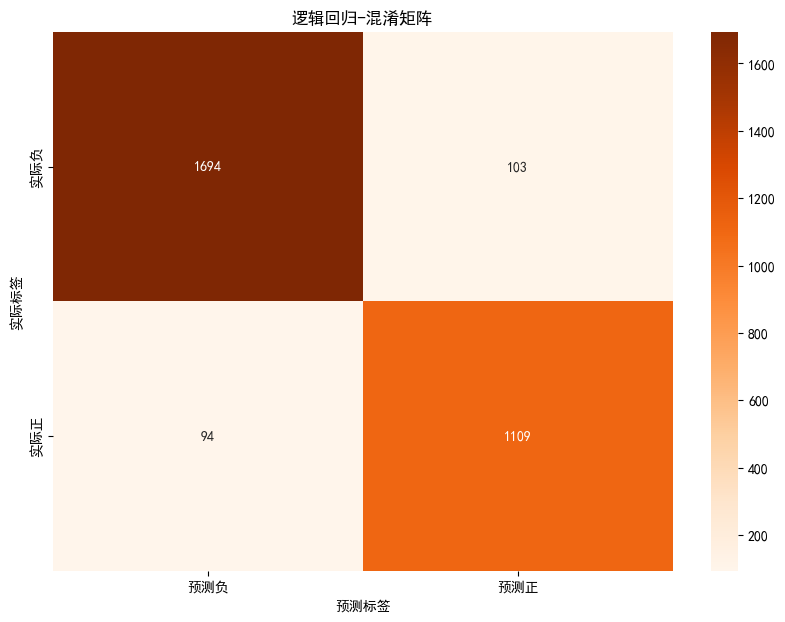

F1 Score: 0.9184


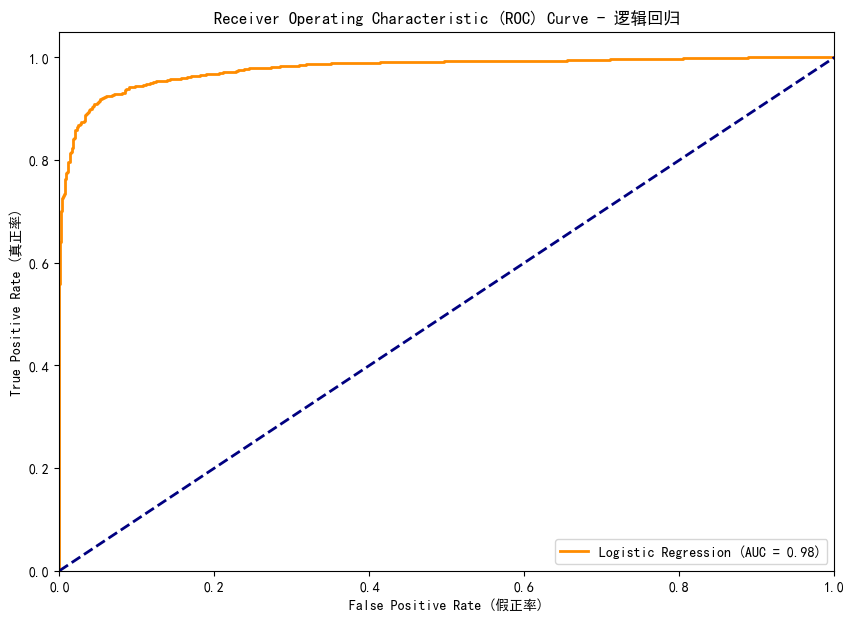

In [11]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import time

# 初始化计时
start = time.time()


# 逻辑回归核心正则化参数C，solver选适配多分类/二分类的liblinear，penalty为L2正则
param_distributions = {
    'C': [0.1, 0.3, 1],  # 正则化强度，越小正则化越强
    'solver': ['liblinear'],  # 逻辑回归专用求解器，适配二分类/小数据集
    'penalty': ['l2']  # 正则化方式，L2为默认
}
# 初始化逻辑回归模型
lr = LogisticRegression(random_state=42)
# 随机搜索最优参数（cv=5交叉验证，n_iter=5搜索次数）
random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_distributions,
    n_iter=5,
    cv=5,
    random_state=42
)
# 训练模型（拟合训练集）
random_search.fit(X_train, y_train)

# 输出最优参数
print('最优参数是{}'.format(random_search.best_params_))

# 用最优参数初始化最终逻辑回归模型
# 提取最优参数
C_best = random_search.best_params_['C']
solver_best = random_search.best_params_.get('solver', 'liblinear')
penalty_best = random_search.best_params_.get('penalty', 'l2')

lr_best = LogisticRegression(
    C=C_best,
    solver=solver_best,
    penalty=penalty_best,
    random_state=42
)
# 用最优模型拟合训练集
lr_best.fit(X_train, y_train)

# 输出模型训练耗时
end = time.time()
print('逻辑回归训练花费时间: {:.4f}秒'.format(end - start))

# 模型预测与评分（训练集+测试集）
start = time.time()
train_score = lr_best.score(X_train, y_train)  # 训练集准确率
test_score = lr_best.score(X_test, y_test)      # 测试集准确率
end = time.time()

# 输出准确率和预测耗时
print('训练集准确率: {:.4f}'.format(train_score))
print('测试集准确率: {:.4f}'.format(test_score))
print('预测花费时间: {:.4f}秒'.format(end - start))


# 测试集预测结果（类别）
y_pred = lr_best.predict(X_test)
# 测试集预测概率（正例概率，[:,1]取第二列，对应正例）
lr_pred_prob = lr_best.predict_proba(X_test)[:, 1]

# 4.1 绘制混淆矩阵（评估分类精准度：真负/假正/假负/真正）
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,  # 显示数值
    fmt='d',     # 数值格式为整数
    cmap='Oranges',
    xticklabels=['预测负', '预测正'],
    yticklabels=['实际负', '实际正']
)
plt.xlabel('预测标签')
plt.ylabel('实际标签')
plt.title('逻辑回归-混淆矩阵')
plt.show()

# 输出F1分数（兼顾精确率和召回率，比准确率更适合不平衡数据）
print('F1 Score: {:.4f}'.format(f1_score(y_test, y_pred)))

# 绘制ROC曲线并计算AUC值（评估模型区分能力，AUC越接近1越好）
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_prob)  # 计算假正率/真正率
roc_auc_lr = auc(fpr_lr, tpr_lr)                      # 计算AUC值

plt.figure(figsize=(10, 7))
# 绘制逻辑回归ROC曲线
plt.plot(
    fpr_lr, tpr_lr,
    color='darkorange',
    lw=2,
    label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr
)
# 绘制随机猜测基准线（对角线）
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# 坐标轴范围
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# 坐标轴标签和标题
plt.xlabel('False Positive Rate (假正率)')
plt.ylabel('True Positive Rate (真正率)')
plt.title('Receiver Operating Characteristic (ROC) Curve - 逻辑回归')
plt.legend(loc="lower right")  # 图例位置
plt.show()

In [13]:
#抽取50条进行检验
import random

y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


test_total = len(X_test)
sample_num = 50  # 抽取样本数
# 限制start范围：0 ≤ start ≤ 测试集长度-50，若测试集不足50条，直接取全部
if test_total < sample_num:
    start = 0
    sample_num = test_total
    print(f"测试集仅{test_total}条数据，不足50条，将抽取全部数据测试")
else:
    start = random.randint(0, test_total - sample_num)  # 修正原100-2400的硬编码，适配任意测试集长度

# 抽取50条数据（特征+标签），因已重置索引，切片后样本完全匹配
X_data = X_test[start:start+sample_num]
y_data = y_test[start:start+sample_num]
success_test = 0


for sequence_index in range(len(X_data)):
 
    comment_words = all_words[start + sequence_index]
    # 拼接分词结果输出（处理空评论情况）
    comment_str = '/'.join(comment_words) if comment_words else '【空评论】'
    print(f"评论分词结果：{comment_str}")
    # 模型预测（传入二维数组，适配sklearn要求）
    x_sample = X_data[sequence_index:sequence_index+1]  
    res = lr_best.predict(x_sample)[0]  # 取预测结果的标量值（0/1）
    # 【关键修正5】标签用数值类型0/1判断，与模型训练/预测结果一致
    # 输出预测结果
    if res == 0:             
        print('Predict result : 好评', end='\t')             
    else:              
        print('Predict result : 差评', end='\t')            
    # 输出实际结果（y_data已重置索引，直接用位置索引访问，数值类型）
    y_actual = y_data.iloc[sequence_index]  # 用iloc确保位置访问，兼容Series
    if y_actual == 0:
        print('Actual results: 好评', end='\t')
    else:   
        print('Actual results: 差评', end='\t')
    # 判断预测是否正确
    if res == y_actual:
        print('Predict success!', end='\t')
        success_test += 1
    else:
        print('Predict fail!', end='\t')
    print('\n' + '-'*80 + '\n')  
# 计算并输出预测准确度
accuracy = success_test / sample_num
print(f'本次支持向量机测试共抽取{sample_num}条数据，预测准确度为: {accuracy:.4f}（{success_test}/{sample_num}）')

评论分词结果：东西/不错/不错/不错/不错/苹果/笔记本/好好/好好/好好/看中/做工/精细/看好/系统/做工/精致/听说/贬值/运行/速度/屏幕/效果/柔和/伤/眼睛/真的/稳定/散热/性能/还好/不太/外形/外观/美极了/妙极了
Predict result : 差评	Actual results: 差评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：京东/一如既往/谱/正版/商品/发货/速度/很快/京东/小哥/力/提前/送达/运行/速度/M1pro/芯片/杠杠/没得说/屏幕/效果/支持/高刷/屏幕/看着/爽/办公/娱乐/很棒/14/寸/16/寸太大/携带/真的/重/适合/携带/感觉/14/寸/刚刚/散热/性能/剪辑/视频/文档/风扇/转/凉爽/重度/转/外形/外观/工艺品/铝合金/机身/质感/方正/造型/商务/轻薄/程度/14/寸/刚刚/重/携带方便/特色/MacBook/Pro/搭载/m1/芯片/说/行业/天花板/玩游戏/丝滑
Predict result : 差评	Actual results: 差评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：运行/速度/满意/屏幕/效果/精致/散热/性能/满意/外形/外观/漂亮/轻薄/程度/轻薄/特色/满意/下单/价格/优惠/散热/能力/满意/运行/速度/非常适合/学习/一点/不卡顿/喜欢
Predict result : 差评	Actual results: 差评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：工作/原因/终于/入手/心心念念/MacBookpro/国行/全新/听说/新款/快递/力/早上/下单/下午/喜欢
Predict result : 差评	Actual results: 差评	Predict suc

#### 相比SVM，逻辑回归模型的训练时间更短，但是准确率可能低于SVM

#### 4.逻辑回归的核心使用场景  
- 核心场景：二分类任务（最常用）：如垃圾邮件识别（是 / 否）、信用违约预测（违约 / 不违约）、癌症检测（患病 / 未患病），输出明确类别；
- 扩展场景：多分类任务（通过 One-vs-Rest 等策略实现）：如手写数字识别（0-9）、花卉种类分类（玫瑰 / 百合 / 菊花）；
- 特殊场景：概率型类回归: 如点击概率、患病概率预测，输出 0-1 的连续概率值（非标准回归）
- 无法用于标准回归任务

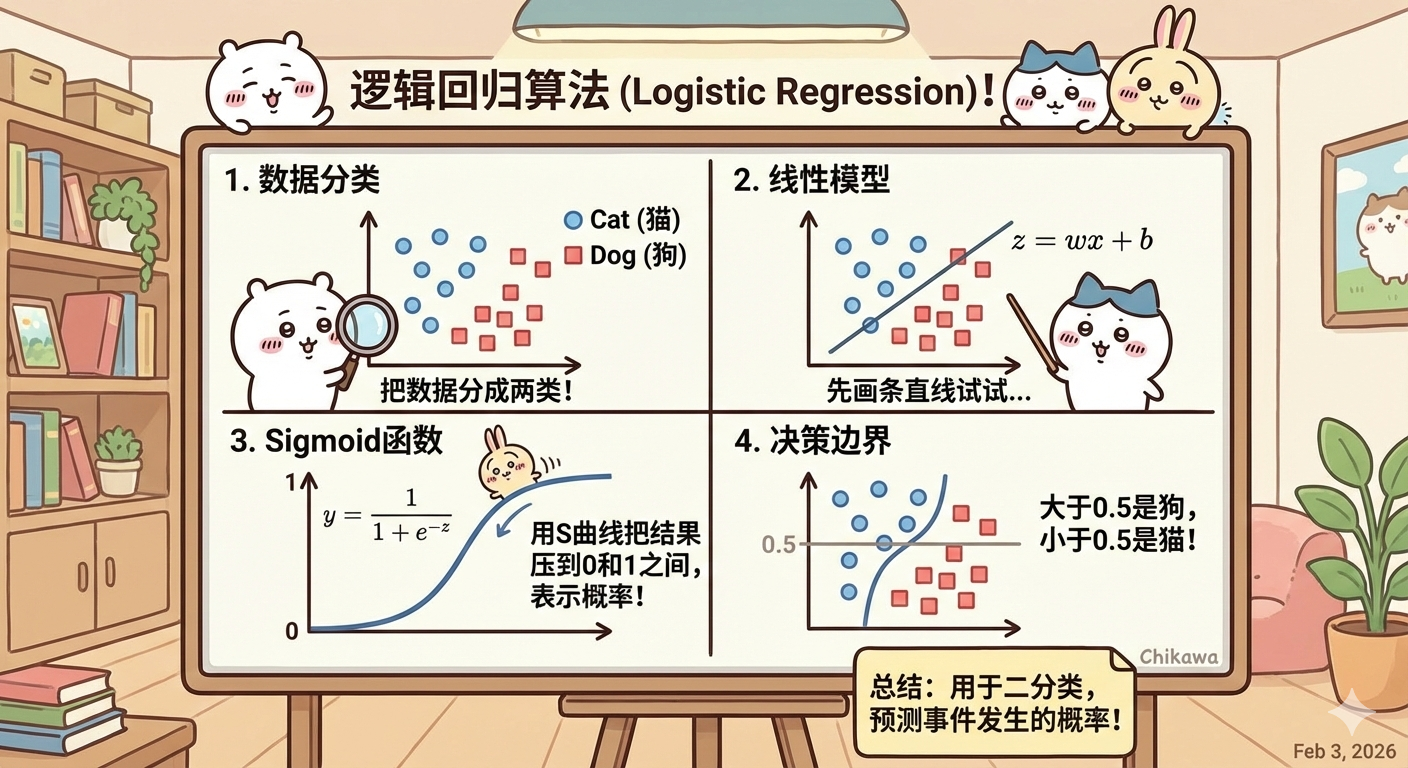

#### 在逻辑回归的超参数中，penalty有L1和L2两种，L1是Lasso回归，L2是Ridge回归。下一个lecture会对正则化线性模型进行详细介绍